# OpenAi Acrobot
[Documentation](https://gymnasium.farama.org/environments/classic_control/acrobot/)

## imports

In [1]:
import os
import time
import math
import gymnasium as gym
import numpy as np
from numpy import inf
import random
import imageio
from IPython.display import clear_output
from IPython import display
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from PIL import Image
%matplotlib inline

## Global variables

In [2]:
EPISODES = 25000
SHOW_EVERY = 250
RANDOM_SEED = random.randint(1, 5000)
# RANDOM_SEED = 3847 # comment for a random seed
RANDOM_SEED

107

## Get env informations

In [3]:
env = gym.make("Acrobot-v1", render_mode="rgb_array")
obs, _ = env.reset()

high = env.observation_space.high
low = env.observation_space.low
print(f"high\t\t=\t{high}")
print(f"low\t\t=\t{low}")
print(f"observations\t=\t{obs}")
print(f"len_obs\t\t=\t{len(high)}")
print(f"action_space\t=\t{env.action_space.n}")
print(f"reward_threshold=\t{env.spec.reward_threshold}")

high		=	[ 1.        1.        1.        1.       12.566371 28.274334]
low		=	[ -1.        -1.        -1.        -1.       -12.566371 -28.274334]
observations	=	[ 0.9999155  -0.01299944  0.9956811   0.09283944 -0.04184029  0.051858  ]
len_obs		=	6
action_space	=	3
reward_threshold=	-100.0


## Set-up the Agent

In [4]:
class Agent():
    def __init__(self, bin_size: int = 10, seed: int = None):
        self.env = gym.make("Acrobot-v1", render_mode="rgb_array")
        self.seed = seed
        if self.seed:
            self.env.action_space.seed(self.seed)
            np.random.seed(self.seed)
            
        # init env
        self.reset()
        self.state_space = len(env.observation_space.high) # number of states (Position, Velocity, Angle, Angular Velocity): 4
        self.action_space = self.env.action_space.n # number of possible actions (0, 1): 2
        self.bin_size = bin_size
        self.q_table, self.discrete_os_win_size = self.Qtable()
        
        # Epsilon
        self.epsilon = 0.5
    
    def reset(self):
        if self.seed:
            return self.env.reset(seed=self.seed)
        else:
            return self.env.reset()

    def __get_last(self, l):
        return None if len(l) <= 0 else l[-1]
    
    def Qtable(self):
        high = env.observation_space.high
        low = env.observation_space.low
        
        discrete_os_size = [self.bin_size] * self.state_space
        discrete_os_win_size = (high - low) / np.subtract(discrete_os_size, [1])
        q_table = np.random.uniform(low=-2, high=2, size=(discrete_os_size + [self.action_space]))
        return q_table, discrete_os_win_size
    
    def get_discrete(self, state):
        low = env.observation_space.low
        discrete_state = (state - low) / self.discrete_os_win_size
        return tuple(discrete_state.astype(np.int64))
    
    def policy(self, state: tuple):
        # Choosing action based on epsilon-greedy policy
        return np.argmax(self.q_table[state])
    
    def new_Q_value(self, reward: float, new_state: tuple, gamma = 0.95) -> float:
        # Maximum possible QValue in the next step
        max_future_q = np.max(self.q_table[new_state])
        learned_value = reward + gamma * max_future_q
        return learned_value
    
    def learning_rate(self) -> float:
        return 0.1
    
    def update_exploration_rate(self, episode: int) -> float:
        start_epsilon_decaying = 1
        end_epsilon_decaying = EPISODES // 2
        epsilon_decay_value = self.epsilon / (end_epsilon_decaying - start_epsilon_decaying)
        if end_epsilon_decaying >= episode >= start_epsilon_decaying:
            self.epsilon -= epsilon_decay_value
    
    def fit(self, episodes = 2000):
        rewards = []
        aggr_ep_rewards = {'ep': [], 'avg': [], 'min': [], 'max': []}
        solved = 0

        for episode in range(episodes):
            print(f"{episode + 1}/{episodes} : sloved=({solved} => {int(solved * 100 / (episode+1))}%) | avg: {self.__get_last(aggr_ep_rewards['avg'])} min: {self.__get_last(aggr_ep_rewards['min'])} max: {self.__get_last(aggr_ep_rewards['max'])}", end="\r")
            # episode initialization 
            discrete_state = self.get_discrete(self.reset()[0])
            score = 0
            step = 0
            done = False

            # learning loop for the current episode
            while not done:
                # action selection
                if np.random.random() > self.epsilon:
                    action = self.policy(discrete_state) # policy action
                else:
                    action = self.env.action_space.sample() # random action

                # increment environment
                observation, reward, terminated, truncated, info = self.env.step(action)
                done = terminated or truncated
                next_state = self.get_discrete(observation)
                score += reward
                
                # If the simulation did not end - updating Q table
                if not done:
                    # learning from environnement
                    lr = self.learning_rate()
                    learnt_value = self.new_Q_value(reward, next_state)
                    # Current Qvalue for the current state and selected action
                    current_q = self.q_table[discrete_state + (action, )]
                    # QLearning equation to calculate the new Qvalue
                    new_q = (1-lr) * current_q + lr * learnt_value
                    # Updating Qtable
                    self.q_table[discrete_state + (action, )] = new_q
                    
                # if simulation ended and goal position is achived
                elif score >= self.env.spec.reward_threshold:
                    self.q_table[discrete_state + (action, )] = 0
                    # End of the episode update
                    solved += 1
                
                discrete_state = next_state
                
                step += 1
                
            # Updating epsilon rate
            self.update_exploration_rate(episode)
                
            rewards += [score]
            if not episode % SHOW_EVERY:
                average_reward = sum(rewards[-SHOW_EVERY:])/len(rewards[-SHOW_EVERY:])
                aggr_ep_rewards['ep'] += [episode]
                aggr_ep_rewards['avg'] += [average_reward]
                aggr_ep_rewards['min'] += [min(rewards[-SHOW_EVERY:])]
                aggr_ep_rewards['max'] += [max(rewards[-SHOW_EVERY:])]
                
        self.env.close()
        print("\nEnd")
        return rewards, aggr_ep_rewards
    
    def render(self):
        img = plt.imshow(self.env.render())
        current_state = self.get_discrete(self.env.reset()[0])
        for t in range(1000):
            action = self.policy(current_state)
            observation, reward, terminated, truncated, info = self.env.step(action)
            done = terminated or truncated

            img.set_data(self.env.render())
            plt.axis('off')
            plt.suptitle(f"Timestep=({t})")
            display.display(plt.gcf())
            clear_output(wait=True)

            if done:
                observation, info = self.reset()
                break
            else:
                current_state = self.get_discrete(observation)

        self.env.close()
    
    def __update_plot(self, frame_number, current_state, num_iteration):
        """
        Updates the plot.

        Args:
        - frame_number (int): The current frame number.
        - current_state (np.ndarray): The current state.
        - num_iteration (int): The current number of iterations.

        Returns:
        - image (np.ndarray): The current image.
        - frame_number (int): The updated frame number.
        - current_state (np.ndarray): The current state.
        - num_iteration (int): The updated number of iterations.
        """
        # Get action from policy
        action = self.policy(current_state)
        # Take a step in the environment
        observation, reward, terminated, truncated, info = self.env.step(action)
        done = terminated or truncated
        # Render the current state and convert it to a plot
        state = self.env.render()
        # converting state to plot in order to stylize it
        fig = Figure()
        canvas = FigureCanvas(fig)
        ax = fig.add_subplot(1,1,1)
        ax.imshow(state)
        ax.axis('off')
        ax.set_title(f"Timestep=({frame_number})")
        canvas.draw()
        # Convert plot back to an image
        size = fig.get_size_inches() * fig.dpi
        image = np.frombuffer(canvas.tostring_rgb(), dtype='uint8').reshape(int(size[1]), int(size[0]), 3)

        if done:
            # If episode is done, reset the environment
            observation, info = self.reset()
            num_iteration -= 1
            time.sleep(0.5)
            frame_number = 0
        else:
            # Otherwise, increment the frame number
            current_state = self.get_discrete(observation)
            frame_number += 1
        return image, frame_number, current_state, num_iteration
    
    def save(self):
        # Get the initial state and render it
        current_state = self.get_discrete(self.reset()[0])
        frame = self.env.render()
        # Initialize the number of iterations and frames
        num_iteration = 5
        images = []
        frame_number = 0
        # Run the simulation for num_iteration iterations
        while num_iteration > 0:
            print(f"{(5 - num_iteration)+1}/{5}", end="\r")
            # Update the plot and append the resulting image to images
            frame, frame_number, current_state, num_iteration = self.__update_plot(frame_number, current_state, num_iteration)
            images.append(Image.fromarray(frame))
        # Save the images as a gif
        print("\nSaving..............", end="\r")     
        images[0].save('img/acrobot.gif', format='GIF', save_all=True, append_images=images[1:], duration=50, loop=0)
        print("Saved")

In [5]:
agent_argmax = Agent(bin_size=30)
rewards_argmax, aggr_ep_rewards_argmax = agent_argmax.fit(episodes = EPISODES)

25000/25000 : sloved=(0 => 0%) | avg: -410.608 min: -500.0 max: -153.0
End


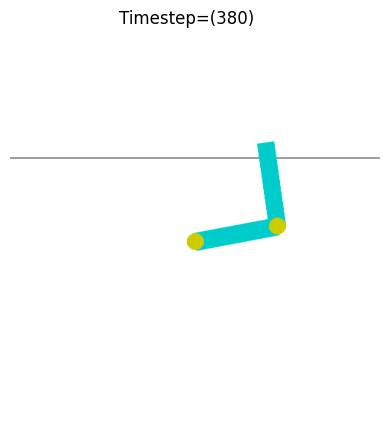

In [6]:
agent_argmax.render()

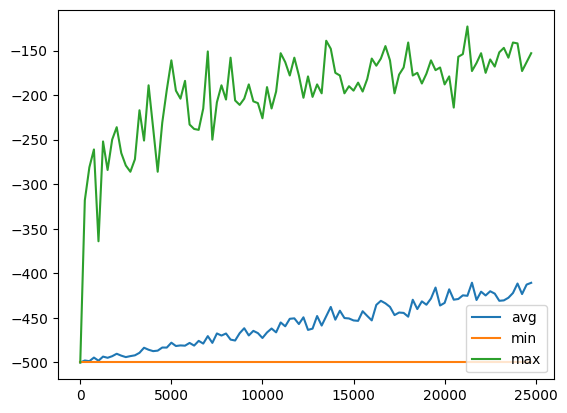

In [7]:
plt.plot(aggr_ep_rewards_argmax['ep'], aggr_ep_rewards_argmax['avg'], label="avg")
plt.plot(aggr_ep_rewards_argmax['ep'], aggr_ep_rewards_argmax['min'], label="min")
plt.plot(aggr_ep_rewards_argmax['ep'], aggr_ep_rewards_argmax['max'], label="max")
plt.legend(loc=4)
plt.show()

In [8]:
agent_argmax.save()

5/5
Savedg..............
